# Predict Energy Building Project

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import holidays
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingRegressor
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score


In [2]:
building = pd.read_csv("D:/Đồ án KTDL/Dataset/building_metadata.csv")
energy = pd.read_csv("D:/Đồ án KTDL/Dataset/train.csv",parse_dates=["timestamp"])
weather = pd.read_csv("D:/Đồ án KTDL/Dataset/weather_train.csv",parse_dates=["timestamp"])

In [3]:
train, test = train_test_split(energy, test_size=0.1, random_state=42)

In [4]:
combined = train.join(building.set_index('building_id'), on='building_id').join(weather.set_index(['site_id', 'timestamp']), on=['site_id', 'timestamp'])

# Statistics

In [5]:
numeric = ['meter_reading', 'square_feet', 'floor_count', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr',
           'sea_level_pressure', 'wind_direction', 'wind_speed']
numeric_desc = combined[numeric].describe().T
numeric_desc['top'] = combined[numeric].apply(lambda x: x.value_counts().index[0])
numeric_desc['rarest'] = combined[numeric].apply(lambda x: x.value_counts().index[-1])
numeric_desc

,count,mean,std,min,25%,50%,75%,max,top,rarest
meter_reading,18194490.0,2103.998701,152488.831915,0.0,18.3,78.7631,267.9,21904700.0,0.0,41.6244
square_feet,18194490.0,107768.272790,117118.505897,283.0,32527.0,72709.0000,139113.0,875000.0,387638.0,49500.0000
floor_count,3156690.0,4.184896,4.008976,1.0,1.0,3.0000,6.0,26.0,1.0,14.0000
air_temperature,18107556.0,15.989148,10.947407,-28.9,8.6,16.7000,24.1,47.2,24.4,-21.2000
dew_temperature,18104415.0,7.747878,10.178652,-35.0,0.0,8.9000,16.1,26.1,10.0,-24.3000
precip_depth_1_hr,14821010.0,0.795986,7.468641,-1.0,0.0,0.0000,0.0,343.0,0.0,98.0000
sea_level_pressure,17085546.0,1016.085227,7.060886,968.2,1011.6,1016.0000,1020.5,1045.5,1015.2,975.0000
wind_direction,16890287.0,173.021667,114.058194,0.0,70.0,180.0000,280.0,360.0,0.0,198.0000
wind_speed,18065171.0,3.377657,2.265836,0.0,2.1,3.1000,4.6,19.0,0.0,3.2000


In [6]:
category = ["site_id", "building_id", "primary_use", "year_built", "meter", "timestamp", "cloud_coverage"]
category_desc = combined[category].astype('object').describe(include="object").T
category_desc['rarest'] = combined[category].apply(lambda x: x.value_counts().index[-1])
category_desc['rarest_count'] = combined[category].apply(lambda x: x.value_counts().min())
category_desc

,count,unique,top,freq,rarest,rarest_count
site_id,18194490,16,13,2440816,11,107356
building_id,18194490,1449,1249,31736,403,426
primary_use,18194490,16,Education,7348821,Religious worship,29221
year_built,7279325.0,116.0,1976.0,478108.0,1972.0,7653
meter,18194490,4,0,10854962,3,1138203
timestamp,18194490,8784,2016-06-20 15:00:00,2169,2016-03-13 02:00:00,1395
cloud_coverage,10250779.0,10.0,0.0,5177156.0,5.0,17026


# Data Visualization

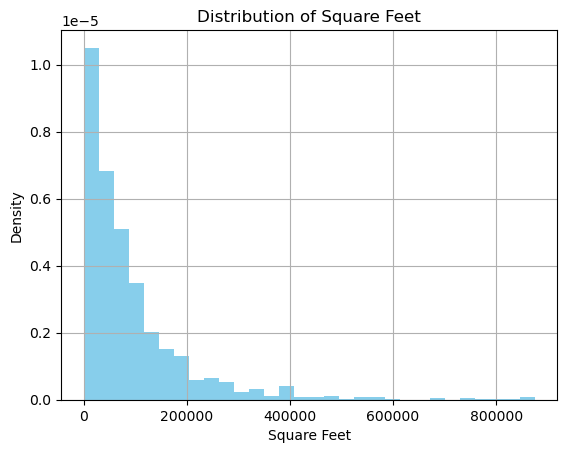

In [7]:
plt.hist(building["square_feet"], bins=30, density=True, color='skyblue')
plt.xlabel('Square Feet')
plt.ylabel('Density')
plt.title('Distribution of Square Feet')
plt.grid(True)
plt.show()

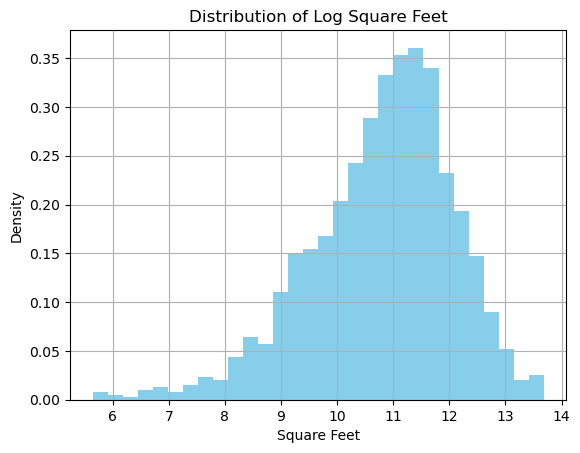

In [8]:
plt.hist(np.log(building["square_feet"]), bins=30, density=True, color='skyblue')
plt.xlabel('Square Feet')
plt.ylabel('Density')
plt.title('Distribution of Log Square Feet')
plt.grid(True)
plt.show()

In [9]:
def missing_data_summary(df):    
    null_counts = df.isnull().sum()
    null_percentage = round((null_counts / len(df)) * 100, 2)
    
    missing_data = pd.DataFrame({
        'Missing': null_counts,
        '%': null_percentage
    })
    
    missing_data = missing_data.sort_values(by='%', ascending=False)
    return missing_data

In [10]:
missing_data_summary(building)

,Missing,%
floor_count,1094,75.50
year_built,774,53.42
site_id,0,0.00
building_id,0,0.00
primary_use,0,0.00
square_feet,0,0.00


In [ ]:
def downcast(df):
    for col in df.columns:
        col_data = df[col]
        dn = col_data.dtype.name
        if dn == "object":
            df[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="integer")
        elif dn == "bool":
            df[col] = col_data.astype("int8")
        elif dn.startswith("int") or (col_data.round() == col_data).all():
            df[col] = pd.to_numeric(col_data, downcast="integer")
        else:
            df[col] = pd.to_numeric(col_data, downcast='float')
    return df

In [13]:
d_combined= downcast(combined.drop(columns="timestamp"))

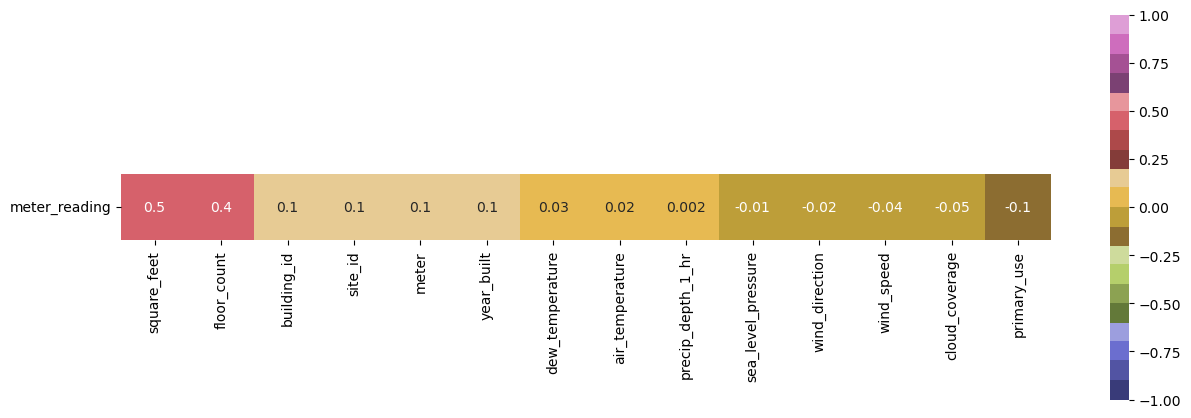

In [14]:
corr_matrix = d_combined.corr(method ="spearman")
corr_matrix_y = corr_matrix['meter_reading'].drop('meter_reading').sort_values(ascending=False)
sorted_columns = corr_matrix_y.index
sorted_corr_matrix = corr_matrix.loc[['meter_reading'], sorted_columns]
plt.figure(figsize=(15, 5))
sns.heatmap(sorted_corr_matrix, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')
plt.yticks(rotation=0)
plt.show()

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\891283688.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=mean_air, x='hour', y='air_temperature', marker='o', palette='viridis')


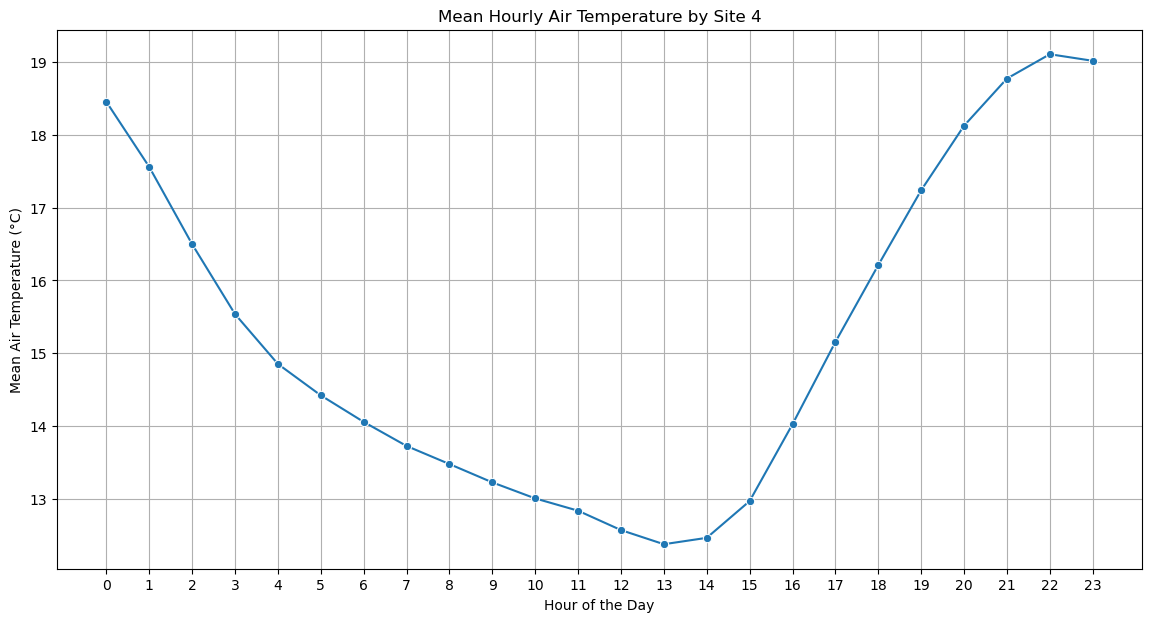

In [15]:
weather_plot = weather.copy()
weather_plot['hour'] = weather_plot['timestamp'].dt.hour
mean_air = weather_plot[weather_plot['site_id'] == 4].groupby('hour')['air_temperature'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_air, x='hour', y='air_temperature', marker='o', palette='viridis')
plt.grid(True)
plt.xticks(ticks=range(24))
plt.title('Mean Hourly Air Temperature by Site 4')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Air Temperature (°C)')
plt.show()

In [16]:
weather_site =weather.pivot_table(index='timestamp', columns='site_id', values='air_temperature')
weather_site

site_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
timestamp,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,25.0,3.8,15.6,10.0,NaN,NaN,NaN,-1.8,25.0,NaN,NaN,-1.8,1.9,-8.3,NaN,NaN
2016-01-01 01:00:00,24.4,3.7,13.9,9.4,9.4,5.0,10.0,-1.7,24.4,10.0,-10.6,-1.7,1.6,-8.3,5.6,-1.0
2016-01-01 02:00:00,22.8,2.6,13.3,8.9,8.3,3.0,10.0,-2.7,22.8,10.0,-11.1,-2.7,0.7,-7.8,5.6,-1.0
2016-01-01 03:00:00,21.1,2.0,12.2,7.8,7.8,4.0,9.4,-2.3,21.1,10.0,-10.0,-2.3,0.8,-7.8,5.6,-1.0
2016-01-01 04:00:00,20.0,2.3,11.7,7.8,5.0,4.0,7.8,-2.6,20.0,10.0,-13.3,-2.6,2.9,-7.2,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,22.8,8.1,15.0,9.4,12.8,9.0,8.9,-10.3,22.8,21.7,-4.4,-10.3,9.7,-3.3,6.7,3.0
2016-12-31 20:00:00,23.3,7.2,16.1,8.9,11.1,8.0,8.9,-9.9,23.3,21.7,-4.4,-9.9,9.7,-3.9,5.6,2.8
2016-12-31 21:00:00,23.3,6.9,16.7,8.9,11.1,8.0,8.9,-9.9,23.3,23.9,-4.4,-9.9,8.6,-4.4,5.6,2.8


In [17]:
weather_city = pd.read_csv("D:/Đồ án KTDL/Dataset/temperature.csv",parse_dates=["datetime"]).set_index('datetime')
weather_city -= 273.15
weather_city

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.950000,NaN,NaN,NaN
2012-10-01 13:00:00,11.480000,8.930000,16.330000,8.650000,18.720000,18.380000,20.260000,23.450000,11.970000,11.460000,...,12.480000,15.070000,12.680000,14.020000,34.440000,32.320000,37.430000,31.25,31.25,30.35
2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,11.457306,...,12.513208,15.097676,12.684650,14.036092,34.440000,31.160000,37.345769,31.25,31.25,30.35
2012-10-01 15:00:00,11.476998,8.941866,16.310618,8.639833,18.712844,18.393355,20.242177,23.481487,12.083952,11.449918,...,12.606824,15.176940,12.697790,14.081672,34.241513,31.131841,37.261538,31.25,31.25,30.35
2012-10-01 16:00:00,11.474955,8.950481,16.296243,8.632449,18.707503,18.403209,20.231213,23.504466,12.163345,11.442530,...,12.700440,15.256203,12.710929,14.127251,33.995200,31.088015,37.177308,31.25,31.25,30.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,NaN,8.850000,NaN,7.670000,20.400000,19.000000,16.390000,21.560000,12.570000,16.410000,...,17.090000,NaN,1.980000,14.930000,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,9.740000,NaN,8.500000,22.530000,19.590000,17.460000,22.440000,13.300000,17.550000,...,16.090000,NaN,0.980000,12.870000,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,10.240000,NaN,9.600000,22.810000,19.430000,18.190000,23.100000,13.290000,16.560000,...,13.630000,NaN,0.330000,10.790000,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
find_city = weather_site.join(weather_city, on='timestamp')
find_city_corr = find_city.corr(method='pearson')[weather_site.columns].drop(weather_site.columns)
find_city_corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Vancouver,0.594818,0.550734,0.828921,0.750030,0.666910,0.549105,0.729205,0.748203,0.594818,0.733591,0.849120,0.748203,0.494899,0.789576,0.740747,0.705483
Portland,0.556228,0.480531,0.786820,0.696287,0.697454,0.483872,0.677715,0.697120,0.556228,0.685122,0.802523,0.697120,0.426382,0.708205,0.690612,0.664330
San Francisco,0.531249,0.343936,0.766882,0.589284,0.911195,0.357514,0.591632,0.578901,0.531249,0.655244,0.735562,0.578901,0.301514,0.596363,0.592317,0.566764
Seattle,0.577660,0.501046,0.808742,0.717513,0.710358,0.503149,0.699151,0.714481,0.577660,0.699372,0.819134,0.714481,0.451666,0.730676,0.708745,0.677556
Los Angeles,0.565455,0.379493,0.788275,0.621541,0.761708,0.385566,0.621676,0.597032,0.565455,0.655524,0.739639,0.597032,0.343722,0.605682,0.622500,0.587626
San Diego,0.567545,0.398526,0.768168,0.605372,0.716894,0.396247,0.607934,0.577803,0.567545,0.642703,0.714813,0.577803,0.359173,0.589040,0.607472,0.569335
Las Vegas,0.655264,0.598512,0.926893,0.783039,0.690267,0.604269,0.760213,0.764701,0.655264,0.777342,0.911566,0.764701,0.552610,0.802595,0.771991,0.727187
Phoenix,0.687972,0.571876,0.970606,0.778359,0.733403,0.577833,0.766823,0.762021,0.687972,0.799416,0.898756,0.762021,0.529182,0.789633,0.770072,0.722959
Albuquerque,0.670919,0.543535,0.885586,0.724284,0.688245,0.539759,0.724170,0.712189,0.670919,0.841560,0.850403,0.712189,0.497334,0.765052,0.721790,0.686641
Denver,0.637963,0.588626,0.844137,0.720620,0.649681,0.588148,0.709611,0.719578,0.637963,0.793658,0.865406,0.719578,0.550719,0.798851,0.718785,0.683883


In [19]:
site_city = pd.concat([find_city_corr.idxmax(),find_city_corr.max()], axis=1).reset_index().rename(columns={'index':'site_id',0:'city',1:'corr'})
site_city

,site_id,city,corr
0,0,Jacksonville,0.936877
1,1,Toronto,0.722419
2,2,Phoenix,0.970606
3,3,Philadelphia,0.973229
4,4,San Francisco,0.911195
5,5,Toronto,0.725674
6,6,Philadelphia,0.960275
7,7,Montreal,0.981699
8,8,Jacksonville,0.936877
9,9,San Antonio,0.975012


C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\1973544282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_site_1512['hour'] = weather_site_1512['timestamp'].dt.hour


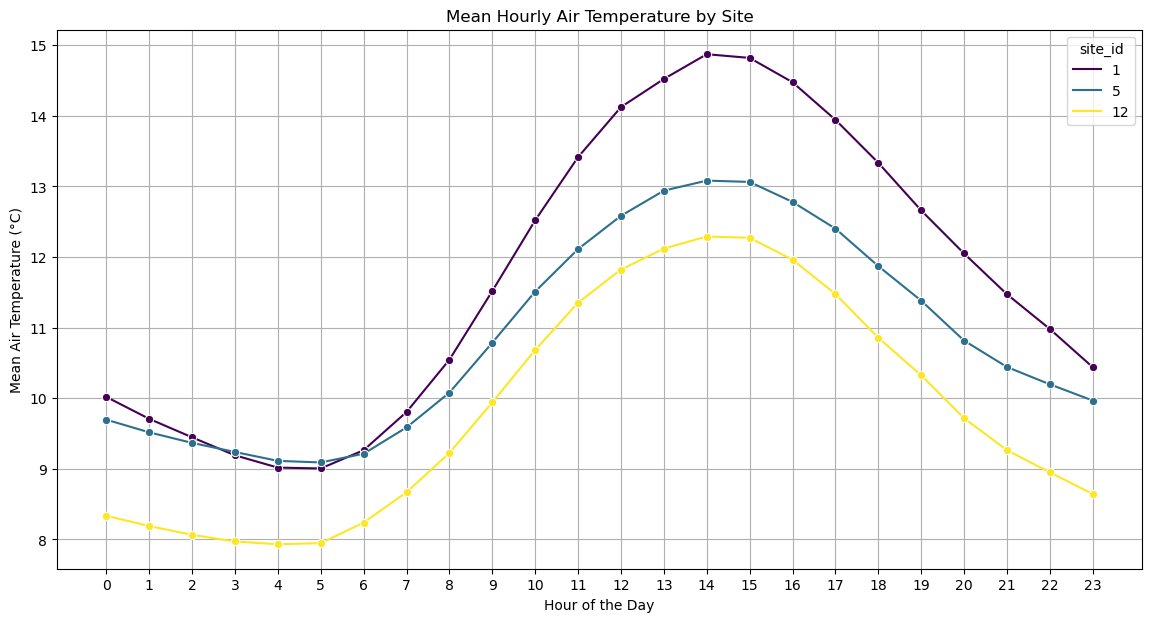

In [20]:
weather_site_1512 = weather[weather['site_id'].isin([1,5,12])]
weather_site_1512['hour'] = weather_site_1512['timestamp'].dt.hour
mean_hour = weather_site_1512.groupby(['site_id', 'hour'])['air_temperature'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_hour, x='hour', y='air_temperature', hue='site_id', marker='o', palette='viridis')
plt.grid(True)
plt.xticks(ticks=range(24))
plt.title('Mean Hourly Air Temperature by Site')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Air Temperature (°C)')
plt.show()

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\3193594925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_site_01['hour'] = weather_site_01['timestamp'].dt.hour


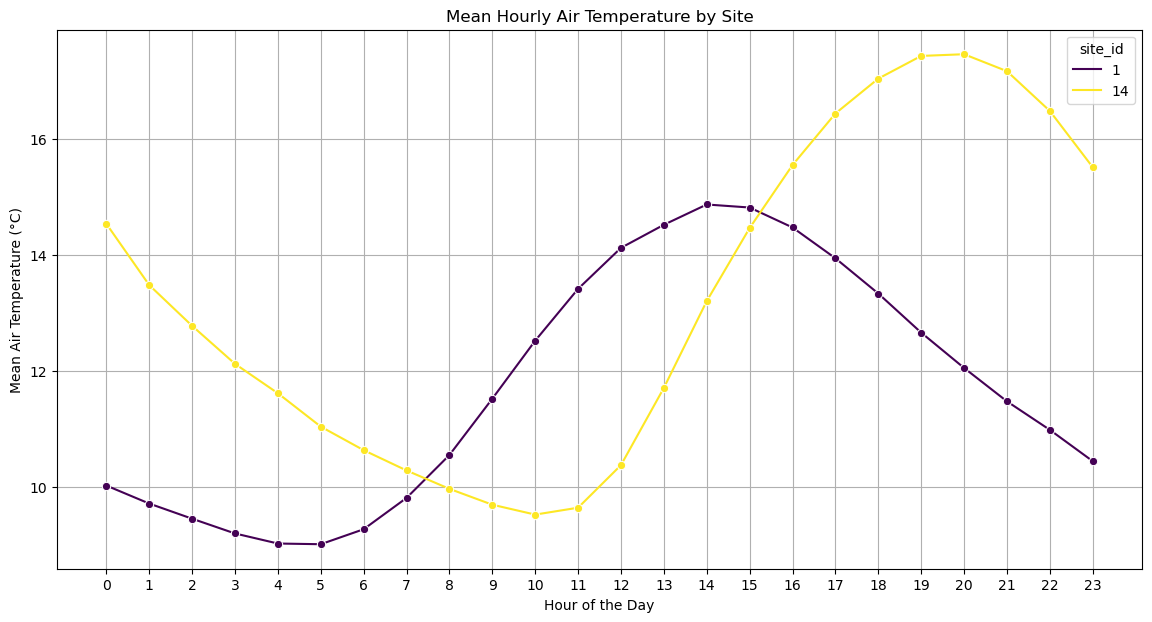

In [21]:
weather_site_01 = weather[weather['site_id'].isin([1,14])]
weather_site_01['hour'] = weather_site_01['timestamp'].dt.hour
mean_hour = weather_site_01.groupby(['site_id', 'hour'])['air_temperature'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_hour, x='hour', y='air_temperature', hue='site_id', marker='o', palette='viridis')
plt.grid(True)
plt.xticks(ticks=range(24))
plt.title('Mean Hourly Air Temperature by Site')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Air Temperature (°C)')
plt.show()

In [22]:
england_holidays = holidays.UK(years=2016, subdiv='ENG')
ireland_holidays = holidays.IE(years=2016)
 
england_dates = set(england_holidays.keys())
ireland_dates = set(ireland_holidays.keys())
unique_england_holidays = {date: name for date, name in england_holidays.items() if date not in ireland_dates}
unique_ireland_holidays = {date: name for date, name in ireland_holidays.items() if date not in england_dates}

print("List of England holidays(not in Ireland):")
for date, name in sorted(unique_england_holidays.items()):
    print(date, name)

print("\nList of Ireland holidays(not in England):")
for date, name in sorted(unique_ireland_holidays.items()):
    print(date, name)


List of England holidays(not in Ireland):
2016-03-25 Good Friday
2016-05-30 Spring Bank Holiday
2016-08-29 Late Summer Bank Holiday
2016-12-27 Christmas Day (observed)

List of Ireland holidays(not in England):
2016-03-17 St. Patrick's Day
2016-06-06 June Bank Holiday
2016-08-01 August Bank Holiday
2016-10-31 October Bank Holiday


In [23]:
site_energy = energy.join(building.set_index('building_id'), on='building_id')

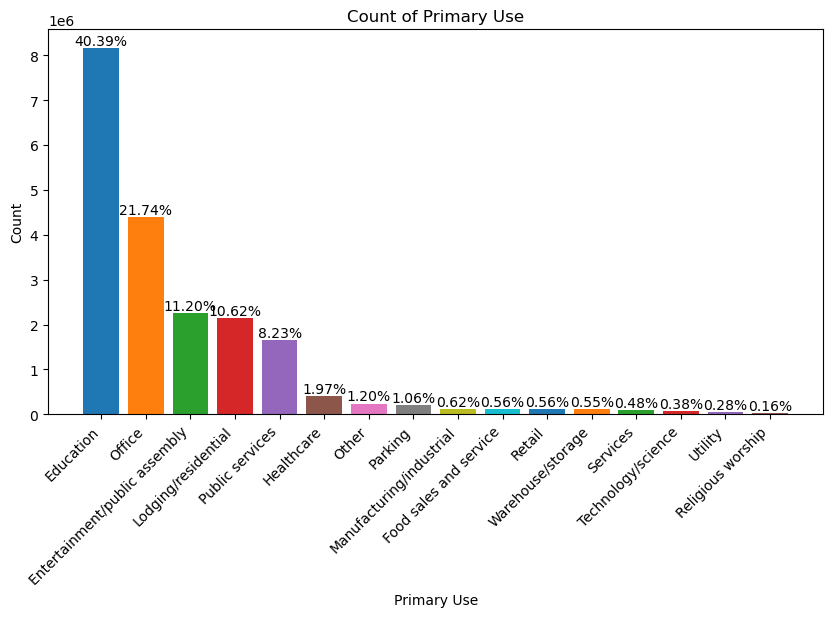

In [24]:
primary_use_counts = site_energy['primary_use'].value_counts()
total_counts = primary_use_counts.sum()
colors = plt.get_cmap('tab10').colors
plt.figure(figsize=(10, 5))
bars = plt.bar(primary_use_counts.index, primary_use_counts,color=colors[:len(primary_use_counts)])
for bar, count in zip(bars, primary_use_counts):
    height = bar.get_height()
    percentage = f'{(count / total_counts) * 100:.2f}%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom')

plt.xlabel('Primary Use')
plt.ylabel('Count')
plt.title('Count of Primary Use')
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
site_energy = site_energy.loc[(site_energy['primary_use'] == 'Education') & (site_energy['timestamp'].dt.weekday < 5)]
site_energy['timestamp'] = site_energy['timestamp'].dt.normalize()
site_energy = site_energy.groupby(['site_id', 'timestamp']).agg({'meter_reading': 'mean'}).reset_index()


In [26]:
def draw_mr_plot(df,site_id):
    plt.figure(figsize=(20, 7))    
    
    england_dates = [np.datetime64(date) for date, _ in unique_england_holidays.items()]
    ireland_dates = [np.datetime64(date) for date, _ in unique_ireland_holidays.items()]
    
    legend_labels = {}  
    
    sns.lineplot(data=df, x='timestamp', y='meter_reading', ci=False)
    
    for date in england_dates:
        if 'England' not in legend_labels: 
            plt.scatter(
                date, df[df['timestamp'] == date]['meter_reading'], color='red', marker='o', s=100, alpha=0.8, label='England')
            legend_labels['England'] = True  
        else:
            plt.scatter(date, df[df['timestamp'] == date]['meter_reading'], color='red', marker='o', s=100, alpha=0.8)
        plt.text(date, df[df['timestamp'] == date]['meter_reading'] - 3, str(date), ha='center', va='top')
    
    for date in ireland_dates:
        if 'Ireland' not in legend_labels:  
            plt.scatter(
                date, df[df['timestamp'] == date]['meter_reading'], color='gold', marker='o', s=100, alpha=0.8, label='Ireland')
            legend_labels['Ireland'] = True  
        else:
            plt.scatter(date, df[df['timestamp'] == date]['meter_reading'], color='gold', marker='o', s=100, alpha=0.8)
        plt.text(date, df[df['timestamp'] == date]['meter_reading'] + 5, str(date), ha='center', va='bottom')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Meter Reading')
    plt.title(f'Trend Meter Reading at Site {site_id}')
    plt.grid(True)
    plt.legend()
    plt.show()

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\2758171667.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data=df, x='timestamp', y='meter_reading', ci=False)
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


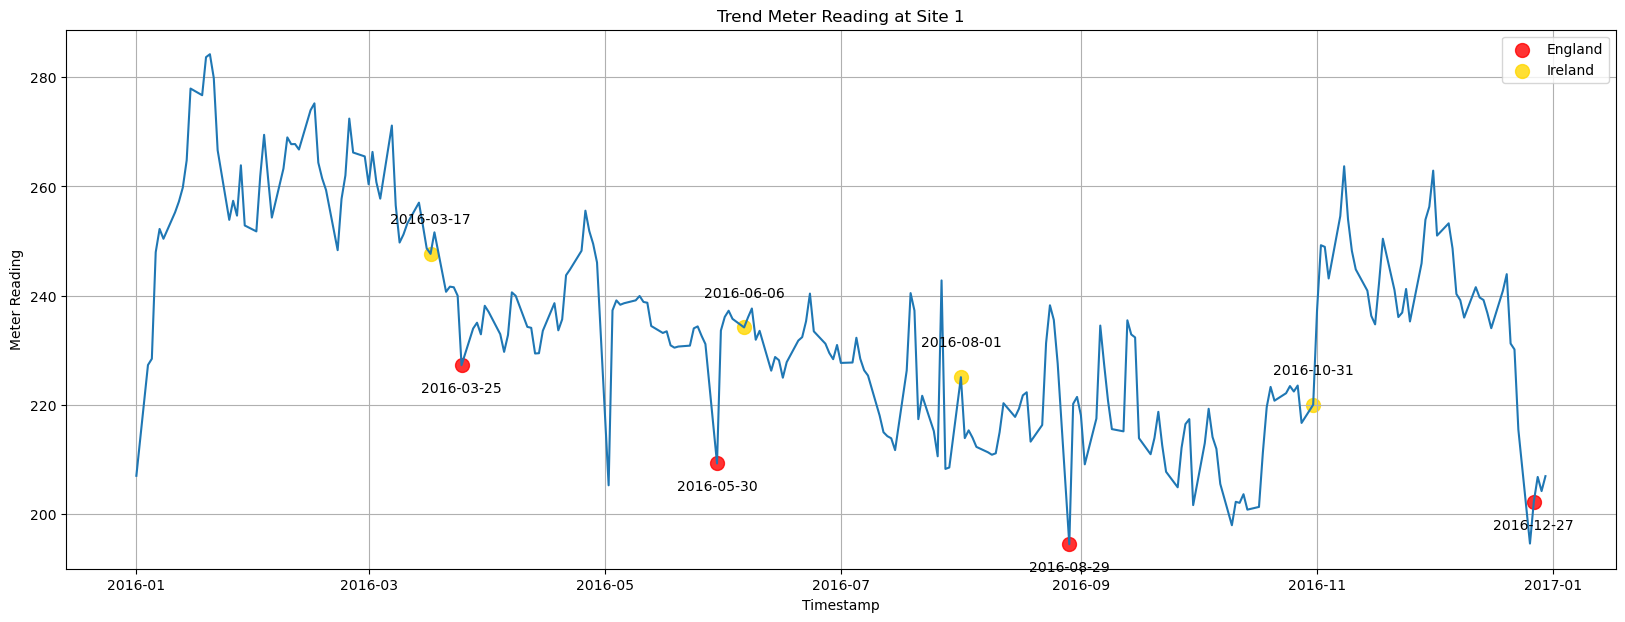

In [27]:
draw_mr_plot(site_energy[site_energy['site_id'] == 1],1)

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\2758171667.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data=df, x='timestamp', y='meter_reading', ci=False)
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


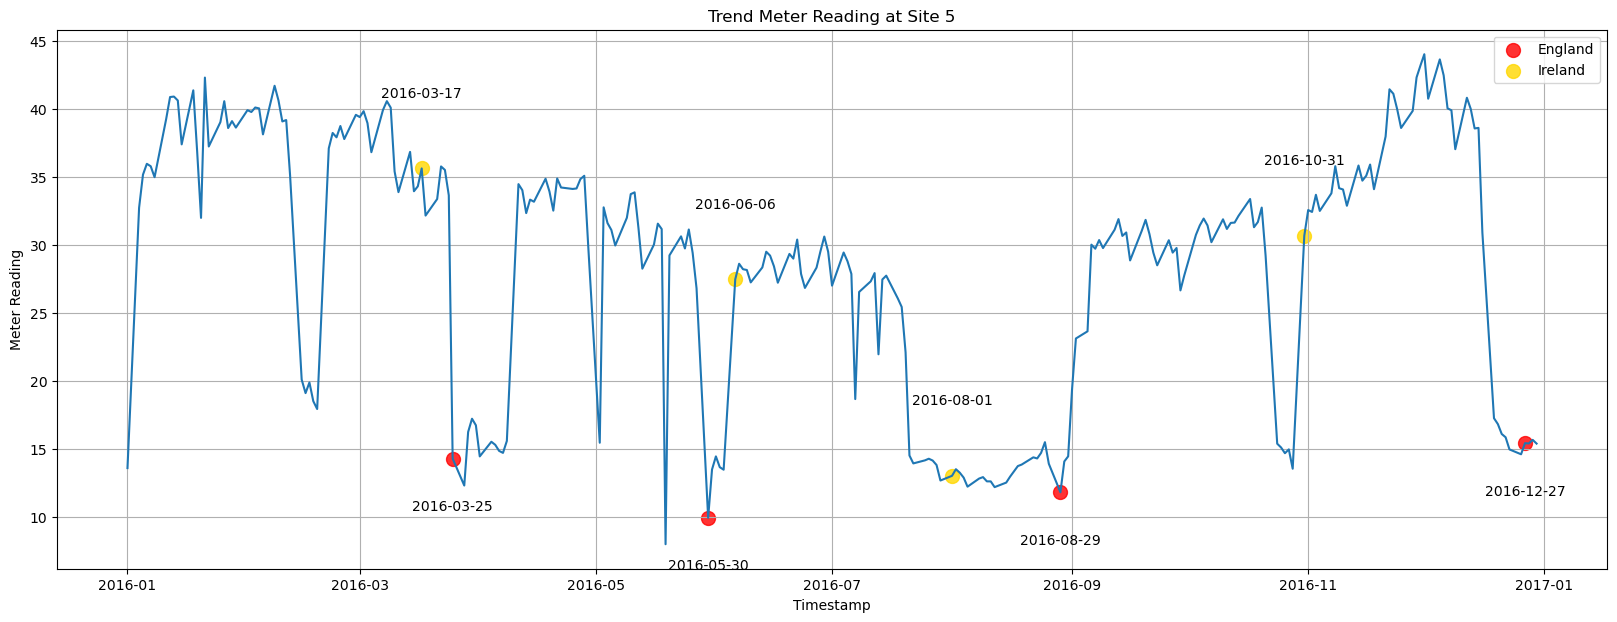

In [28]:
draw_mr_plot(site_energy[site_energy['site_id'] == 5],5)

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\2758171667.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data=df, x='timestamp', y='meter_reading', ci=False)
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


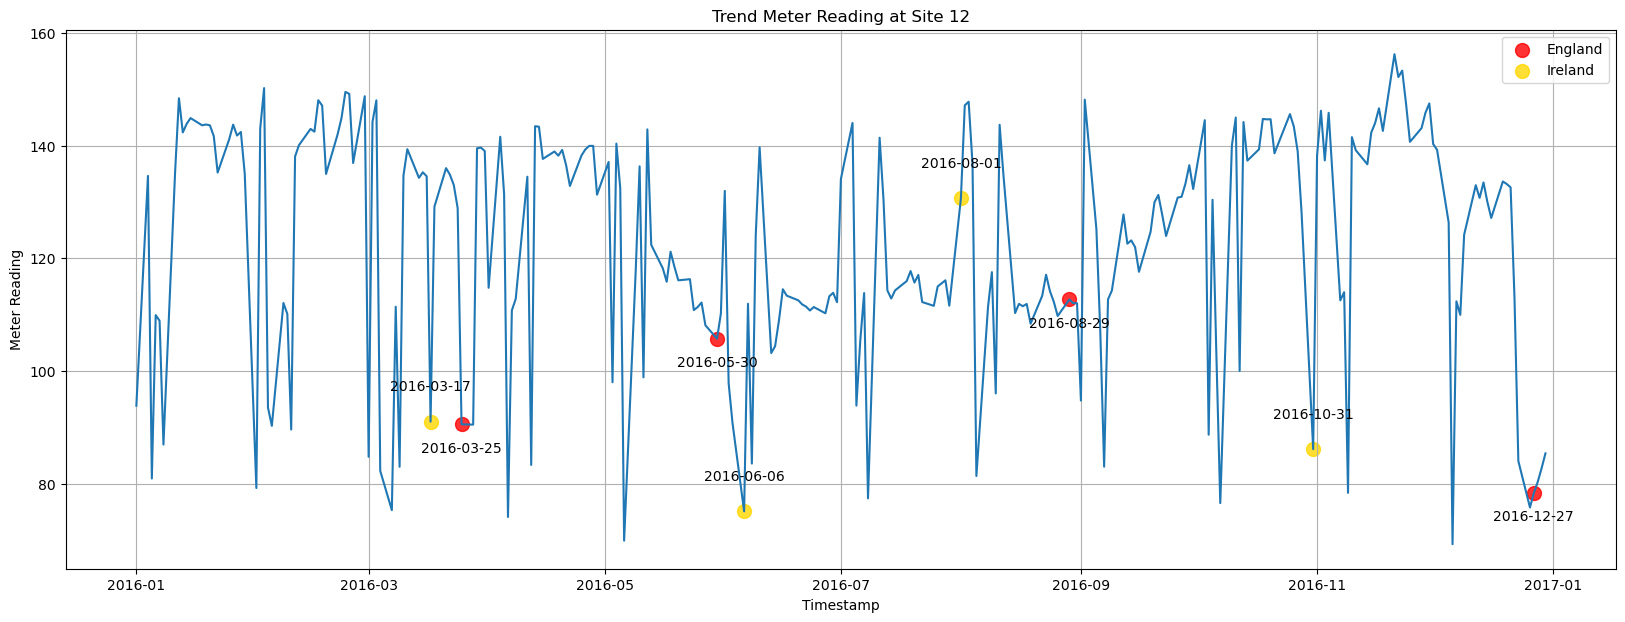

In [29]:
draw_mr_plot(site_energy[site_energy['site_id'] == 12],12)

In [30]:
site_city.loc[1, 'city'] = 'London'
site_city.loc[5, 'city'] = 'Loughborough'
site_city.loc[12, 'city'] = 'Dublin'
site_city.drop(columns=["corr"],inplace=True)
site_city["gmt"] = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]
site_city

,site_id,city,gmt
0,0,Jacksonville,-5
1,1,London,0
2,2,Phoenix,-7
3,3,Philadelphia,-5
4,4,San Francisco,-8
5,5,Loughborough,0
6,6,Philadelphia,-5
7,7,Montreal,-5
8,8,Jacksonville,-5
9,9,San Antonio,-6


In [31]:
missing_data_summary(weather)

,Missing,%
cloud_coverage,69173,49.49
precip_depth_1_hr,50289,35.98
sea_level_pressure,10618,7.60
wind_direction,6268,4.48
wind_speed,304,0.22
dew_temperature,113,0.08
air_temperature,55,0.04
site_id,0,0.00
timestamp,0,0.00


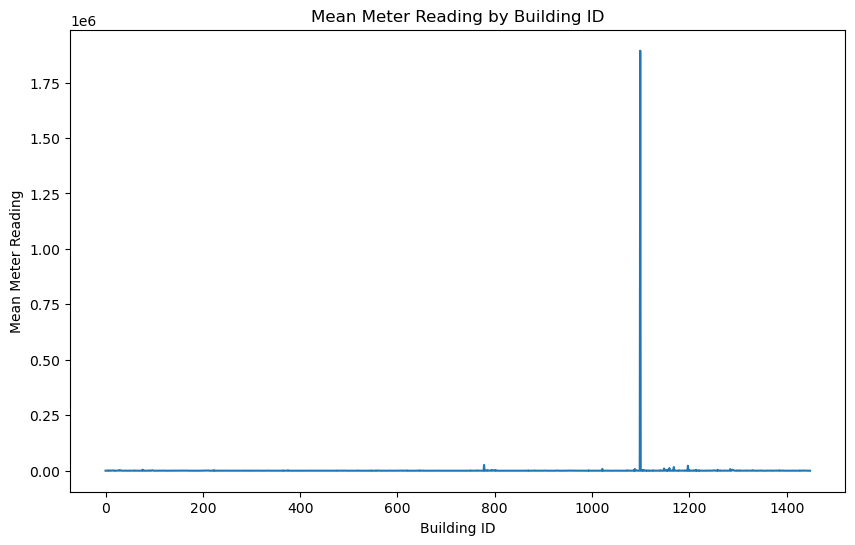

In [32]:
mean_meter_reading_by_building = train.groupby('building_id')['meter_reading'].mean()
plt.figure(figsize=(10, 6))
plt.plot(mean_meter_reading_by_building.index, mean_meter_reading_by_building.values)
plt.xlabel('Building ID')
plt.ylabel('Mean Meter Reading')
plt.title('Mean Meter Reading by Building ID')
plt.show()

C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\460831745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["date"]= data_filtered["timestamp"].dt.date


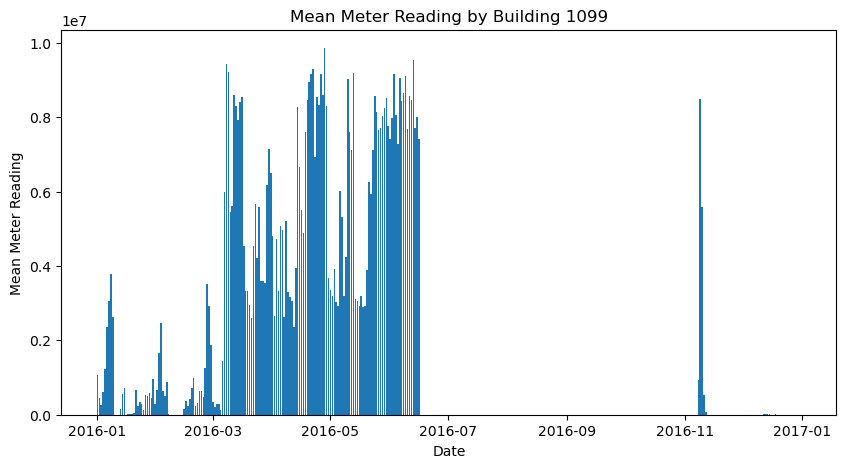

In [33]:
data_filtered = train[train['building_id'] == 1099]
data_filtered["date"]= data_filtered["timestamp"].dt.date
data_average = data_filtered.groupby(["date"])['meter_reading'].mean()
plt.figure(figsize=(10, 5))
plt.bar(data_average.index, data_average.values)
plt.xlabel("Date")
plt.ylabel("Mean Meter Reading")
plt.title('Mean Meter Reading by Building 1099')
plt.show()

In [34]:
building[building["year_built"]==2016]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
28,0,28,Office,52957,2016.0,NaN
45,0,45,Retail,15304,2016.0,NaN
46,0,46,Retail,9045,2016.0,NaN
99,0,99,Office,2260,2016.0,NaN
103,0,103,Education,21657,2016.0,NaN
409,3,409,Education,38500,2016.0,NaN
567,4,567,Entertainment/public assembly,82670,2016.0,4.0


C:\Users\THAI NGOC DUNG\AppData\Local\Temp\ipykernel_10328\1432893746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["date"]= data_filtered["timestamp"].dt.date


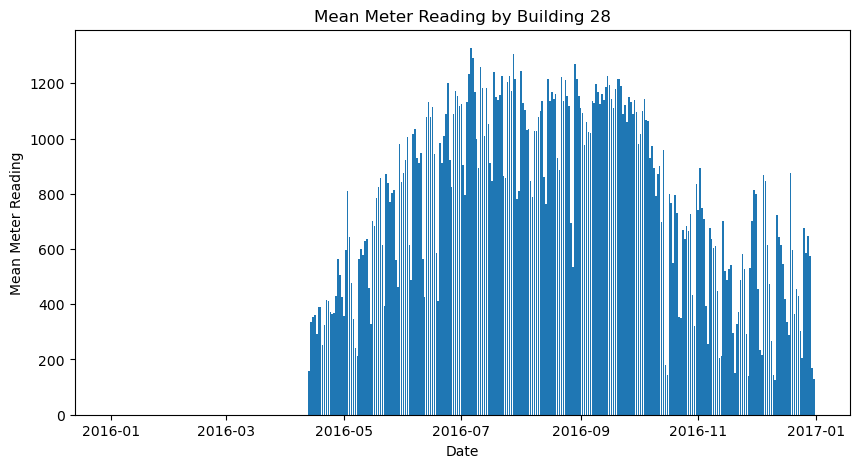

In [35]:
data_filtered = train[(train['building_id'] == 28) ]
data_filtered["date"]= data_filtered["timestamp"].dt.date
data_average = data_filtered.groupby(["date"])['meter_reading'].mean()
plt.figure(figsize=(10, 5))
plt.bar(data_average.index, data_average.values)
plt.xlabel("Date")
plt.ylabel("Mean Meter Reading")
plt.title('Mean Meter Reading by Building 28')
plt.show()

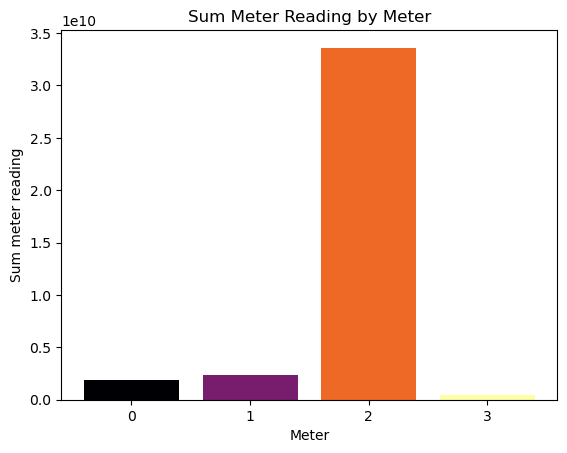

In [36]:
mean_meter_reading = train.groupby('meter')['meter_reading'].sum()
colors = plt.cm.inferno(np.linspace(0, 1, len(mean_meter_reading)))
plt.bar(mean_meter_reading.index, mean_meter_reading.values, color=colors)
plt.xlabel('Meter')
plt.ylabel('Sum meter reading')
plt.title('Sum Meter Reading by Meter')
plt.xticks(mean_meter_reading.index, mean_meter_reading.index)
plt.show()

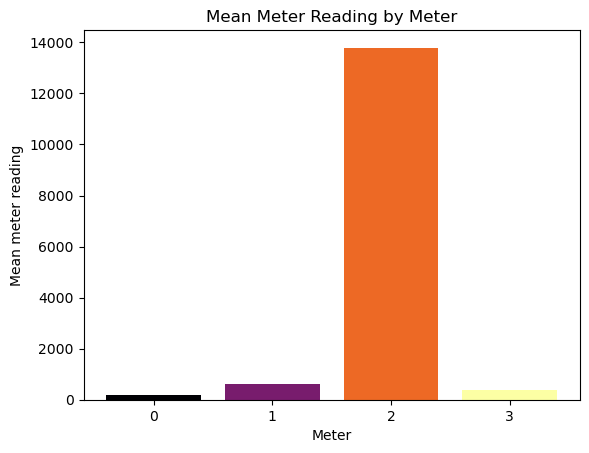

In [37]:
mean_meter_reading = train.groupby('meter')['meter_reading'].mean()
colors = plt.cm.inferno(np.linspace(0, 1, len(mean_meter_reading)))
plt.bar(mean_meter_reading.index, mean_meter_reading.values, color=colors)
plt.xlabel('Meter')
plt.ylabel('Mean meter reading')
plt.title('Mean Meter Reading by Meter')
plt.xticks(mean_meter_reading.index, mean_meter_reading.index)
plt.show()


# Data Preprocessing

In [9]:
def downcast(df):
    for col in df.columns:
        col_data = df[col]
        dn = col_data.dtype.name
        if dn == "object":
            df[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="integer")
        elif dn == "bool":
            df[col] = col_data.astype("int8")
        elif dn.startswith("int") or (col_data.round() == col_data).all():
            df[col] = pd.to_numeric(col_data, downcast="integer")
        else:
            df[col] = pd.to_numeric(col_data, downcast='float')
    return df

In [10]:
def is_holiday(row):
    date_str = f"{row['month']}-{row['day']}"
    if date_str in holidays.US(years=2016,subdiv="FL") and row['city'] == 'Jacksonville':
        return 1
    elif date_str in holidays.UK(years=2016,subdiv="ENG") and row['city'] == 'London':
        return 1
    if date_str in holidays.US(years=2016,subdiv="AZ") and row['city'] == 'Phoenix':
        return 1
    elif date_str in holidays.US(years=2016,subdiv="PA") and row['city'] == 'Philadelphia':
        return 1
    if date_str in holidays.US(years=2016,subdiv="CA") and row['city'] == 'San Francisco':
        return 1
    elif date_str in holidays.UK(years=2016,subdiv="ENG") and row['city'] == 'Loughborough':
        return 1
    if date_str in holidays.CA(years=2016,subdiv="QC") and row['city'] == 'Montreal':
        return 1
    elif date_str in holidays.US(years=2016,subdiv="TX") and row['city'] == 'San Antonio':
        return 1
    if date_str in holidays.US(years=2016,subdiv="NV") and row['city'] == 'Las Vegas':
        return 1
    elif date_str in holidays.IE(years=2016) and row['city'] == 'Dublin':
        return 1
    if date_str in holidays.US(years=2016,subdiv="MN") and row['city'] == 'Minneapolis':
        return 1
    elif date_str in holidays.US(years=2016,subdiv="PA") and row['city'] == 'Toronto':
        return 1
    else:
        return 0

In [11]:
def preprocess_building(df):
    df["square_feet"]=np.log1p(df["square_feet"])
    df.drop(columns=["year_built"], inplace=True)
    df=df.fillna(-1)
    return df

def preprocess_weather(df):
    df["total_hours"]= (df["timestamp"]-pd.to_datetime("2016-01-01")).dt.total_seconds()//3600   
    df = df.join(site_city.set_index('site_id'), on='site_id')
    df["total_hours"] += df["gmt"]
    df = df.loc[df["total_hours"] >= 0]
    
    new_id = pd.MultiIndex.from_product([range(16), range(8784)], names=['site_id', 'total_hours'])
    df = df.set_index(['site_id', 'total_hours']).reindex(new_id).reset_index()
    
    df["timestamp"] = pd.to_datetime("2016-01-01") + pd.to_timedelta(df["total_hours"], unit='h')
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['dayweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    
    df['is_holiday'] = df[["day", "month", "city"]].apply(is_holiday, axis=1)
    
    df.drop(columns=["timestamp","city","gmt"], inplace=True)
    
    for col in df.columns:
        if df[col].isna().sum() / len(df) >= 0.01:
            df[f"had_{col}"] = ~df[col].isna()
            
    df = df.groupby(['site_id','month','day',]).apply(
        lambda group: group.interpolate(limit_direction='both', method='linear')).reset_index(drop=True)
    df = df.groupby(['site_id','month','hour']).apply(
        lambda group: group.interpolate(limit_direction='both', method='linear')).reset_index(drop=True)
    
    df['cloud_coverage'] = df['cloud_coverage'].round()
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].round()
    df['wind_direction'] = df['wind_direction'].round()
    
    site_1 = df.loc[df['site_id'] == 1, ['month', 'day', 'hour', 'sea_level_pressure']]
    site_5 = df.loc[df['site_id'] == 5, ['month', 'day', 'hour', 'sea_level_pressure']]
    joined = site_5.join(
        site_1.set_index(['month', 'day', 'hour']), on=['month', 'day', 'hour'], lsuffix='_site_5', rsuffix='_site_1')
    df.loc[df['site_id'] == 5, 'sea_level_pressure'] = joined['sea_level_pressure_site_1']
    
    df = df.fillna(-1)
    
    return df

def preprocess_train(df):
    df["total_hours"]= (df["timestamp"]-pd.to_datetime("2016-01-01")).dt.total_seconds()//3600
    
    df = df.drop(df[(df["meter_reading"] == 0) & (df["meter"] == 0)].index)
    df = df.drop(df[(df["meter_reading"] == 0) & (df["meter"] == 1) & (df["total_hours"].between(4104, 5639))].index)
    df = df.drop(df[(df["meter_reading"] == 0) & (df["meter"].isin([2, 3])) 
                    & ((df["total_hours"] >= 8520) | (df["total_hours"] <= 1919))].index)
    
    df = df.join(building.set_index('building_id')["site_id"], on='building_id') 
    df.loc[(df['site_id'] == 0) & (df['meter'] == 0), 'meter_reading'] *= 0.2931
    
    df["meter_reading"]=np.log1p(df["meter_reading"])
    
    df.drop(columns=['site_id',"timestamp"], inplace=True)
    return df

def preprocess_test(df):
    df["total_hours"]= (df["timestamp"]-pd.to_datetime("2016-01-01")).dt.total_seconds()//3600
    
    df = df.join(building.set_index('building_id')["site_id"], on='building_id')
    df.loc[(df['site_id'] == 0) & (df['meter'] == 0), 'meter_reading'] *= 0.2931
    
    df.drop(columns=['site_id',"timestamp"], inplace=True)
    return df

In [12]:
building = downcast(preprocess_building(building))
train = downcast(preprocess_train(train))
weather = downcast(preprocess_weather(weather))
combined_train = train.join(building.set_index('building_id'), on='building_id').join(
    weather.set_index(['site_id', 'total_hours']), on=['site_id', 'total_hours'])

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
s=combined_train.drop(columns=["meter_reading","site_id","sea_level_pressure","square_feet", "had_sea_level_pressure", "had_wind_direction", "air_temperature", "had_precip_depth_1_hr"])._get_numeric_data()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(s.values, i) for i in range(s.shape[1])]
vif["features"] = s.columns

In [32]:
vif

,VIF Factor,features
0,4.467052,building_id
1,1.617402,meter
2,1.912471,primary_use
3,1.169476,floor_count
4,2.268703,cloud_coverage
5,1.732395,dew_temperature
6,1.041825,precip_depth_1_hr
7,3.997854,wind_direction
8,4.134477,wind_speed
9,3.519380,hour


# Model Building

In [13]:
y_train = combined_train["meter_reading"]
x_train = combined_train.drop(columns=["meter_reading","total_hours","site_id","sea_level_pressure","square_feet",
                                       "had_sea_level_pressure","had_wind_direction","had_precip_depth_1_hr","air_temperature"])

In [14]:
del train, combined_train
gc.collect()

0

In [15]:
cate_features=['building_id','primary_use','cloud_coverage','hour','day','dayweek','month',"is_holiday",'had_cloud_coverage']

for val in x_train['meter'].unique():
    x1_train = x_train[x_train['meter'] == val].drop(columns=['meter'])
    kf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
    t = 0
    for train_index, val_index in kf.split(x1_train,x1_train["hour"]):

        train_features = x1_train.iloc[train_index]
        train_target = y_train[x1_train.iloc[train_index].index]

        val_features = x1_train.iloc[val_index]
        val_target = y_train[x1_train.iloc[val_index].index]
        
        print("Building model meter :",val,'fold:',t) 
        model_dt = DecisionTreeRegressor(max_depth=30)
        model_dt.fit(train_features, train_target)
        
        val_predictions = model_dt.predict(val_features)
        
        rmse = np.sqrt(mean_squared_error(val_target, val_predictions))
        print("RMSE DT on validation set:", rmse)
        
        locals()['dt_val{}_fold{}'.format(val, t)] = pickle.dumps(model_dt) 
        
        model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', objective = 'regression',
            num_leaves=50,n_estimators=1000,learning_rate=0.3)

        callbacks = [lgb.early_stopping(stopping_rounds=100)]
        model_lgbm.fit(train_features,train_target,eval_set=(val_features, val_target), 
            callbacks=callbacks,categorical_feature=cate_features)
        
        locals()['lgbm_val{}_fold{}'.format(val, t)] = pickle.dumps(model_lgbm)
        
        model_xgb = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,learning_rate=0.3,max_depth=10)
        
        model_xgb.fit(train_features, train_target,eval_set=[(val_features, val_target)], 
                      early_stopping_rounds=100, eval_metric='rmse',verbose=True)
        
        locals()['xgb_val{}_fold{}'.format(val, t)] = pickle.dumps(model_xgb) 
        
        lr = LinearRegression()
        
        model_stack = StackingRegressor(regressors=(model_dt, model_lgbm, model_xgb),meta_regressor=lr)
        model_stack.fit(train_features, train_target)
        
        locals()['stack_val{}_fold{}'.format(val, t)] = pickle.dumps(model_stack) 
        t += 1

Building model meter : 0 fold: 0
RMSE DT on validation set: 0.17761933654688877
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 6918637, number of used features: 14
[LightGBM] [Info] Start training from score 4.101914
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0420483


C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.23775
[1]	validation_0-rmse:1.08020
[2]	validation_0-rmse:0.99493
[3]	validation_0-rmse:0.93875
[4]	validation_0-rmse:0.90368
[5]	validation_0-rmse:0.87885
[6]	validation_0-rmse:0.86368
[7]	validation_0-rmse:0.85211
[8]	validation_0-rmse:0.84404
[9]	validation_0-rmse:0.83806
[10]	validation_0-rmse:0.83214
[11]	validation_0-rmse:0.82684
[12]	validation_0-rmse:0.82102
[13]	validation_0-rmse:0.81822
[14]	validation_0-rmse:0.81502
[15]	validation_0-rmse:0.81002
[16]	validation_0-rmse:0.80897
[17]	validation_0-rmse:0.80812
[18]	validation_0-rmse:0.80064
[19]	validation_0-rmse:0.79919
[20]	validation_0-rmse:0.79684
[21]	validation_0-rmse:0.79338
[22]	validation_0-rmse:0.79127
[23]	validation_0-rmse:0.78952
[24]	validation_0-rmse:0.78879
[25]	validation_0-rmse:0.78447
[26]	validation_0-rmse:0.78202
[27]	validation_0-rmse:0.78128
[28]	validation_0-rmse:0.77932
[29]	validation_0-rmse:0.77834
[30]	validation_0-rmse:0.77594
[31]	validation_0-rmse:0.77282
[32]	validation_0-

[260]	validation_0-rmse:0.73203
[261]	validation_0-rmse:0.73210
[262]	validation_0-rmse:0.73215
[263]	validation_0-rmse:0.73221
[264]	validation_0-rmse:0.73225
[265]	validation_0-rmse:0.73229
[266]	validation_0-rmse:0.73234
[267]	validation_0-rmse:0.73238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6918637, number of used features: 14
[LightGBM] [Info] Start training from score 4.101914
Building model meter : 0 fold: 1
RMSE DT on validation set: 0.17908518017521705
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bi

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.23875
[1]	validation_0-rmse:1.08526
[2]	validation_0-rmse:0.99040
[3]	validation_0-rmse:0.93254
[4]	validation_0-rmse:0.89753
[5]	validation_0-rmse:0.88076
[6]	validation_0-rmse:0.86710
[7]	validation_0-rmse:0.85462
[8]	validation_0-rmse:0.84250
[9]	validation_0-rmse:0.83422
[10]	validation_0-rmse:0.82942
[11]	validation_0-rmse:0.82503
[12]	validation_0-rmse:0.82231
[13]	validation_0-rmse:0.81891
[14]	validation_0-rmse:0.81695
[15]	validation_0-rmse:0.81338
[16]	validation_0-rmse:0.80847
[17]	validation_0-rmse:0.80581
[18]	validation_0-rmse:0.80541
[19]	validation_0-rmse:0.80259
[20]	validation_0-rmse:0.80018
[21]	validation_0-rmse:0.79844
[22]	validation_0-rmse:0.79598
[23]	validation_0-rmse:0.79372
[24]	validation_0-rmse:0.79199
[25]	validation_0-rmse:0.79128
[26]	validation_0-rmse:0.79060
[27]	validation_0-rmse:0.79037
[28]	validation_0-rmse:0.78369
[29]	validation_0-rmse:0.77956
[30]	validation_0-rmse:0.77646
[31]	validation_0-rmse:0.77313
[32]	validation_0-

[260]	validation_0-rmse:0.72812
[261]	validation_0-rmse:0.72817
[262]	validation_0-rmse:0.72820
[263]	validation_0-rmse:0.72823
[264]	validation_0-rmse:0.72832
[265]	validation_0-rmse:0.72839
[266]	validation_0-rmse:0.72843
[267]	validation_0-rmse:0.72844
[268]	validation_0-rmse:0.72846
[269]	validation_0-rmse:0.72850
[270]	validation_0-rmse:0.72843
[271]	validation_0-rmse:0.72850
[272]	validation_0-rmse:0.72851
[273]	validation_0-rmse:0.72850
[274]	validation_0-rmse:0.72852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 6918637, number of used features: 14
[LightGBM] [Info] Start training from score 4.102368
Building model meter : 0 fold: 2
RMSE DT on validation set: 0.17844607183221045
[LightGBM] [Warning] Met negativ

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.23443
[1]	validation_0-rmse:1.08104
[2]	validation_0-rmse:0.99101
[3]	validation_0-rmse:0.93435
[4]	validation_0-rmse:0.89953
[5]	validation_0-rmse:0.88131
[6]	validation_0-rmse:0.86222
[7]	validation_0-rmse:0.84861
[8]	validation_0-rmse:0.83868
[9]	validation_0-rmse:0.83113
[10]	validation_0-rmse:0.82625
[11]	validation_0-rmse:0.82130
[12]	validation_0-rmse:0.81778
[13]	validation_0-rmse:0.81522
[14]	validation_0-rmse:0.80643
[15]	validation_0-rmse:0.80409
[16]	validation_0-rmse:0.80154
[17]	validation_0-rmse:0.79871
[18]	validation_0-rmse:0.79594
[19]	validation_0-rmse:0.79440
[20]	validation_0-rmse:0.79300
[21]	validation_0-rmse:0.79032
[22]	validation_0-rmse:0.78660
[23]	validation_0-rmse:0.78490
[24]	validation_0-rmse:0.78092
[25]	validation_0-rmse:0.78012
[26]	validation_0-rmse:0.77731
[27]	validation_0-rmse:0.77520
[28]	validation_0-rmse:0.77352
[29]	validation_0-rmse:0.77283
[30]	validation_0-rmse:0.76930
[31]	validation_0-rmse:0.76799
[32]	validation_0-

[260]	validation_0-rmse:0.72234
[261]	validation_0-rmse:0.72237
[262]	validation_0-rmse:0.72238
[263]	validation_0-rmse:0.72243
[264]	validation_0-rmse:0.72246
[265]	validation_0-rmse:0.72251
[266]	validation_0-rmse:0.72257
[267]	validation_0-rmse:0.72259
[268]	validation_0-rmse:0.72264
[269]	validation_0-rmse:0.72270
[270]	validation_0-rmse:0.72275
[271]	validation_0-rmse:0.72280
[272]	validation_0-rmse:0.72284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 6918638, number of used features: 14
[LightGBM] [Info] Start training from score 4.102282
Building model meter : 1 fold: 0
RMSE DT on validation set: 0.6885478467449085
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.12157
[1]	validation_0-rmse:1.89237
[2]	validation_0-rmse:1.75350
[3]	validation_0-rmse:1.65180
[4]	validation_0-rmse:1.58996
[5]	validation_0-rmse:1.53768
[6]	validation_0-rmse:1.49975
[7]	validation_0-rmse:1.46262
[8]	validation_0-rmse:1.43794
[9]	validation_0-rmse:1.41686
[10]	validation_0-rmse:1.37708
[11]	validation_0-rmse:1.35722
[12]	validation_0-rmse:1.33978
[13]	validation_0-rmse:1.32840
[14]	validation_0-rmse:1.31774
[15]	validation_0-rmse:1.30236
[16]	validation_0-rmse:1.29320
[17]	validation_0-rmse:1.28212
[18]	validation_0-rmse:1.27556
[19]	validation_0-rmse:1.27120
[20]	validation_0-rmse:1.24904
[21]	validation_0-rmse:1.24011
[22]	validation_0-rmse:1.22895
[23]	validation_0-rmse:1.22207
[24]	validation_0-rmse:1.21664
[25]	validation_0-rmse:1.20884
[26]	validation_0-rmse:1.20088
[27]	validation_0-rmse:1.19091
[28]	validation_0-rmse:1.18599
[29]	validation_0-rmse:1.18228
[30]	validation_0-rmse:1.18014
[31]	validation_0-rmse:1.16908
[32]	validation_0-

[260]	validation_0-rmse:0.98935
[261]	validation_0-rmse:0.98913
[262]	validation_0-rmse:0.98908
[263]	validation_0-rmse:0.98917
[264]	validation_0-rmse:0.98935
[265]	validation_0-rmse:0.98934
[266]	validation_0-rmse:0.98922
[267]	validation_0-rmse:0.98918
[268]	validation_0-rmse:0.98921
[269]	validation_0-rmse:0.98912
[270]	validation_0-rmse:0.98903
[271]	validation_0-rmse:0.98864
[272]	validation_0-rmse:0.98829
[273]	validation_0-rmse:0.98820
[274]	validation_0-rmse:0.98815
[275]	validation_0-rmse:0.98813
[276]	validation_0-rmse:0.98820
[277]	validation_0-rmse:0.98798
[278]	validation_0-rmse:0.98799
[279]	validation_0-rmse:0.98803
[280]	validation_0-rmse:0.98798
[281]	validation_0-rmse:0.98794
[282]	validation_0-rmse:0.98799
[283]	validation_0-rmse:0.98810
[284]	validation_0-rmse:0.98812
[285]	validation_0-rmse:0.98814
[286]	validation_0-rmse:0.98800
[287]	validation_0-rmse:0.98784
[288]	validation_0-rmse:0.98793
[289]	validation_0-rmse:0.98801
[290]	validation_0-rmse:0.98807
[291]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.12350
[1]	validation_0-rmse:1.86633
[2]	validation_0-rmse:1.72683
[3]	validation_0-rmse:1.63387
[4]	validation_0-rmse:1.56786
[5]	validation_0-rmse:1.52337
[6]	validation_0-rmse:1.48163
[7]	validation_0-rmse:1.45275
[8]	validation_0-rmse:1.42898
[9]	validation_0-rmse:1.41305
[10]	validation_0-rmse:1.38946
[11]	validation_0-rmse:1.36434
[12]	validation_0-rmse:1.34942
[13]	validation_0-rmse:1.33054
[14]	validation_0-rmse:1.32307
[15]	validation_0-rmse:1.31036
[16]	validation_0-rmse:1.29565
[17]	validation_0-rmse:1.28239
[18]	validation_0-rmse:1.27417
[19]	validation_0-rmse:1.26332
[20]	validation_0-rmse:1.25777
[21]	validation_0-rmse:1.25312
[22]	validation_0-rmse:1.24190
[23]	validation_0-rmse:1.23686
[24]	validation_0-rmse:1.22816
[25]	validation_0-rmse:1.21626
[26]	validation_0-rmse:1.19808
[27]	validation_0-rmse:1.19131
[28]	validation_0-rmse:1.18203
[29]	validation_0-rmse:1.17606
[30]	validation_0-rmse:1.16894
[31]	validation_0-rmse:1.16317
[32]	validation_0-

[260]	validation_0-rmse:0.97525
[261]	validation_0-rmse:0.97528
[262]	validation_0-rmse:0.97509
[263]	validation_0-rmse:0.97515
[264]	validation_0-rmse:0.97529
[265]	validation_0-rmse:0.97521
[266]	validation_0-rmse:0.97533
[267]	validation_0-rmse:0.97532
[268]	validation_0-rmse:0.97544
[269]	validation_0-rmse:0.97548
[270]	validation_0-rmse:0.97552
[271]	validation_0-rmse:0.97534
[272]	validation_0-rmse:0.97531
[273]	validation_0-rmse:0.97527
[274]	validation_0-rmse:0.97523
[275]	validation_0-rmse:0.97523
[276]	validation_0-rmse:0.97521
[277]	validation_0-rmse:0.97528
[278]	validation_0-rmse:0.97525
[279]	validation_0-rmse:0.97529
[280]	validation_0-rmse:0.97534
[281]	validation_0-rmse:0.97527
[282]	validation_0-rmse:0.97520
[283]	validation_0-rmse:0.97524
[284]	validation_0-rmse:0.97538
[285]	validation_0-rmse:0.97537
[286]	validation_0-rmse:0.97570
[287]	validation_0-rmse:0.97580
[288]	validation_0-rmse:0.97558
[289]	validation_0-rmse:0.97548
[290]	validation_0-rmse:0.97559
[291]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.11607
[1]	validation_0-rmse:1.87000
[2]	validation_0-rmse:1.72312
[3]	validation_0-rmse:1.62900
[4]	validation_0-rmse:1.56727
[5]	validation_0-rmse:1.52277
[6]	validation_0-rmse:1.48835
[7]	validation_0-rmse:1.44958
[8]	validation_0-rmse:1.42192
[9]	validation_0-rmse:1.38648
[10]	validation_0-rmse:1.36940
[11]	validation_0-rmse:1.35581
[12]	validation_0-rmse:1.34834
[13]	validation_0-rmse:1.33643
[14]	validation_0-rmse:1.32047
[15]	validation_0-rmse:1.29905
[16]	validation_0-rmse:1.28388
[17]	validation_0-rmse:1.27089
[18]	validation_0-rmse:1.26579
[19]	validation_0-rmse:1.24983
[20]	validation_0-rmse:1.23891
[21]	validation_0-rmse:1.22368
[22]	validation_0-rmse:1.21606
[23]	validation_0-rmse:1.21137
[24]	validation_0-rmse:1.20920
[25]	validation_0-rmse:1.19862
[26]	validation_0-rmse:1.19367
[27]	validation_0-rmse:1.18857
[28]	validation_0-rmse:1.18022
[29]	validation_0-rmse:1.17805
[30]	validation_0-rmse:1.16559
[31]	validation_0-rmse:1.15514
[32]	validation_0-

[260]	validation_0-rmse:0.96052
[261]	validation_0-rmse:0.96044
[262]	validation_0-rmse:0.96049
[263]	validation_0-rmse:0.96037
[264]	validation_0-rmse:0.96036
[265]	validation_0-rmse:0.96036
[266]	validation_0-rmse:0.96035
[267]	validation_0-rmse:0.96032
[268]	validation_0-rmse:0.96028
[269]	validation_0-rmse:0.96023
[270]	validation_0-rmse:0.96021
[271]	validation_0-rmse:0.96015
[272]	validation_0-rmse:0.95998
[273]	validation_0-rmse:0.96006
[274]	validation_0-rmse:0.96014
[275]	validation_0-rmse:0.96000
[276]	validation_0-rmse:0.95998
[277]	validation_0-rmse:0.95999
[278]	validation_0-rmse:0.95994
[279]	validation_0-rmse:0.95993
[280]	validation_0-rmse:0.96011
[281]	validation_0-rmse:0.96018
[282]	validation_0-rmse:0.96014
[283]	validation_0-rmse:0.96010
[284]	validation_0-rmse:0.96023
[285]	validation_0-rmse:0.96025
[286]	validation_0-rmse:0.96034
[287]	validation_0-rmse:0.96040
[288]	validation_0-rmse:0.96030
[289]	validation_0-rmse:0.96039
[290]	validation_0-rmse:0.96047
[291]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:1.98548
[2]	validation_0-rmse:1.83487
[3]	validation_0-rmse:1.71460
[4]	validation_0-rmse:1.65586
[5]	validation_0-rmse:1.59044
[6]	validation_0-rmse:1.55748
[7]	validation_0-rmse:1.51842
[8]	validation_0-rmse:1.48616
[9]	validation_0-rmse:1.46591
[10]	validation_0-rmse:1.44587
[11]	validation_0-rmse:1.41225
[12]	validation_0-rmse:1.39104
[13]	validation_0-rmse:1.38356
[14]	validation_0-rmse:1.37323
[15]	validation_0-rmse:1.35959
[16]	validation_0-rmse:1.33594
[17]	validation_0-rmse:1.32923
[18]	validation_0-rmse:1.32202
[19]	validation_0-rmse:1.29737
[20]	validation_0-rmse:1.29412
[21]	validation_0-rmse:1.26343
[22]	validation_0-rmse:1.25608
[23]	validation_0-rmse:1.25287
[24]	validation_0-rmse:1.24289
[25]	validation_0-rmse:1.23333
[26]	validation_0-rmse:1.22554
[27]	validation_0-rmse:1.22390
[28]	validation_0-rmse:1.21552
[29]	validation_0-rmse:1.20730
[30]	validation_0-rmse:1.20479
[31]	validation_0-rmse:1.20001
[32]	validation_0-rmse:1.19704
[33]	validation_0

[261]	validation_0-rmse:1.02294
[262]	validation_0-rmse:1.02279
[263]	validation_0-rmse:1.02286
[264]	validation_0-rmse:1.02297
[265]	validation_0-rmse:1.02308
[266]	validation_0-rmse:1.02326
[267]	validation_0-rmse:1.02291
[268]	validation_0-rmse:1.02300
[269]	validation_0-rmse:1.02292
[270]	validation_0-rmse:1.02324
[271]	validation_0-rmse:1.02326
[272]	validation_0-rmse:1.02331
[273]	validation_0-rmse:1.02330
[274]	validation_0-rmse:1.02335
[275]	validation_0-rmse:1.02341
[276]	validation_0-rmse:1.02330
[277]	validation_0-rmse:1.02322
[278]	validation_0-rmse:1.02328
[279]	validation_0-rmse:1.02340
[280]	validation_0-rmse:1.02351
[281]	validation_0-rmse:1.02382
[282]	validation_0-rmse:1.02386
[283]	validation_0-rmse:1.02364
[284]	validation_0-rmse:1.02355
[285]	validation_0-rmse:1.02356
[286]	validation_0-rmse:1.02371
[287]	validation_0-rmse:1.02376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044151 seconds.
You can set `force_row_wise=true

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.21846
[1]	validation_0-rmse:1.95892
[2]	validation_0-rmse:1.80096
[3]	validation_0-rmse:1.68609
[4]	validation_0-rmse:1.61420
[5]	validation_0-rmse:1.56414
[6]	validation_0-rmse:1.52136
[7]	validation_0-rmse:1.48568
[8]	validation_0-rmse:1.44475
[9]	validation_0-rmse:1.41909
[10]	validation_0-rmse:1.40152
[11]	validation_0-rmse:1.37331
[12]	validation_0-rmse:1.34444
[13]	validation_0-rmse:1.33081
[14]	validation_0-rmse:1.30736
[15]	validation_0-rmse:1.29876
[16]	validation_0-rmse:1.28707
[17]	validation_0-rmse:1.26580
[18]	validation_0-rmse:1.25951
[19]	validation_0-rmse:1.25130
[20]	validation_0-rmse:1.24158
[21]	validation_0-rmse:1.23247
[22]	validation_0-rmse:1.21033
[23]	validation_0-rmse:1.20772
[24]	validation_0-rmse:1.20390
[25]	validation_0-rmse:1.19231
[26]	validation_0-rmse:1.18661
[27]	validation_0-rmse:1.17295
[28]	validation_0-rmse:1.16529
[29]	validation_0-rmse:1.16063
[30]	validation_0-rmse:1.15758
[31]	validation_0-rmse:1.15236
[32]	validation_0-

[260]	validation_0-rmse:1.00035
[261]	validation_0-rmse:1.00044
[262]	validation_0-rmse:1.00019
[263]	validation_0-rmse:1.00010
[264]	validation_0-rmse:1.00023
[265]	validation_0-rmse:1.00015
[266]	validation_0-rmse:1.00018
[267]	validation_0-rmse:1.00012
[268]	validation_0-rmse:1.00010
[269]	validation_0-rmse:1.00010
[270]	validation_0-rmse:1.00014
[271]	validation_0-rmse:1.00018
[272]	validation_0-rmse:1.00018
[273]	validation_0-rmse:1.00010
[274]	validation_0-rmse:1.00008
[275]	validation_0-rmse:1.00005
[276]	validation_0-rmse:0.99998
[277]	validation_0-rmse:1.00002
[278]	validation_0-rmse:0.99999
[279]	validation_0-rmse:1.00002
[280]	validation_0-rmse:1.00014
[281]	validation_0-rmse:1.00019
[282]	validation_0-rmse:1.00014
[283]	validation_0-rmse:1.00010
[284]	validation_0-rmse:1.00024
[285]	validation_0-rmse:1.00035
[286]	validation_0-rmse:1.00051
[287]	validation_0-rmse:1.00056
[288]	validation_0-rmse:1.00075
[289]	validation_0-rmse:1.00152
[290]	validation_0-rmse:1.00161
[291]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:2.01630
[2]	validation_0-rmse:1.83656
[3]	validation_0-rmse:1.71959
[4]	validation_0-rmse:1.62951
[5]	validation_0-rmse:1.58302
[6]	validation_0-rmse:1.53693
[7]	validation_0-rmse:1.50549
[8]	validation_0-rmse:1.48028
[9]	validation_0-rmse:1.45136
[10]	validation_0-rmse:1.42265
[11]	validation_0-rmse:1.40251
[12]	validation_0-rmse:1.37548
[13]	validation_0-rmse:1.36536
[14]	validation_0-rmse:1.35665
[15]	validation_0-rmse:1.34482
[16]	validation_0-rmse:1.32428
[17]	validation_0-rmse:1.30831
[18]	validation_0-rmse:1.29672
[19]	validation_0-rmse:1.29218
[20]	validation_0-rmse:1.28271
[21]	validation_0-rmse:1.27638
[22]	validation_0-rmse:1.25667
[23]	validation_0-rmse:1.25069
[24]	validation_0-rmse:1.24654
[25]	validation_0-rmse:1.24002
[26]	validation_0-rmse:1.22339
[27]	validation_0-rmse:1.21867
[28]	validation_0-rmse:1.21063
[29]	validation_0-rmse:1.20352
[30]	validation_0-rmse:1.20116
[31]	validation_0-rmse:1.19617
[32]	validation_0-rmse:1.19414
[33]	validation_0

[261]	validation_0-rmse:1.05727
[262]	validation_0-rmse:1.05714
[263]	validation_0-rmse:1.05729
[264]	validation_0-rmse:1.05745
[265]	validation_0-rmse:1.05747
[266]	validation_0-rmse:1.05756
[267]	validation_0-rmse:1.05760
[268]	validation_0-rmse:1.05769
[269]	validation_0-rmse:1.05782
[270]	validation_0-rmse:1.05774
[271]	validation_0-rmse:1.05766
[272]	validation_0-rmse:1.05776
[273]	validation_0-rmse:1.05784
[274]	validation_0-rmse:1.05790
[275]	validation_0-rmse:1.05787
[276]	validation_0-rmse:1.05802
[277]	validation_0-rmse:1.05821
[278]	validation_0-rmse:1.05816
[279]	validation_0-rmse:1.05826
[280]	validation_0-rmse:1.05821
[281]	validation_0-rmse:1.05857
[282]	validation_0-rmse:1.05867
[283]	validation_0-rmse:1.05865
[284]	validation_0-rmse:1.05869
[285]	validation_0-rmse:1.05888
[286]	validation_0-rmse:1.05910
[287]	validation_0-rmse:1.05913
[288]	validation_0-rmse:1.05908
[289]	validation_0-rmse:1.05917
[290]	validation_0-rmse:1.05926
[291]	validation_0-rmse:1.05940
[292]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:1.60532
[3]	validation_0-rmse:1.49025
[4]	validation_0-rmse:1.40173
[5]	validation_0-rmse:1.34341
[6]	validation_0-rmse:1.28814
[7]	validation_0-rmse:1.24742
[8]	validation_0-rmse:1.21574
[9]	validation_0-rmse:1.19443
[10]	validation_0-rmse:1.17513
[11]	validation_0-rmse:1.16400
[12]	validation_0-rmse:1.13349
[13]	validation_0-rmse:1.11698
[14]	validation_0-rmse:1.10412
[15]	validation_0-rmse:1.08556
[16]	validation_0-rmse:1.07963
[17]	validation_0-rmse:1.07077
[18]	validation_0-rmse:1.06567
[19]	validation_0-rmse:1.06118
[20]	validation_0-rmse:1.05195
[21]	validation_0-rmse:1.04664
[22]	validation_0-rmse:1.03202
[23]	validation_0-rmse:1.02698
[24]	validation_0-rmse:1.02454
[25]	validation_0-rmse:1.01647
[26]	validation_0-rmse:1.01359
[27]	validation_0-rmse:0.99906
[28]	validation_0-rmse:0.99799
[29]	validation_0-rmse:0.99483
[30]	validation_0-rmse:0.99174
[31]	validation_0-rmse:0.98992
[32]	validation_0-rmse:0.98172
[33]	validation_0-rmse:0.97901
[34]	validation_

[262]	validation_0-rmse:0.86160
[263]	validation_0-rmse:0.86142
[264]	validation_0-rmse:0.86126
[265]	validation_0-rmse:0.86135
[266]	validation_0-rmse:0.86141
[267]	validation_0-rmse:0.86137
[268]	validation_0-rmse:0.86150
[269]	validation_0-rmse:0.86141
[270]	validation_0-rmse:0.86115
[271]	validation_0-rmse:0.86117
[272]	validation_0-rmse:0.86114
[273]	validation_0-rmse:0.86102
[274]	validation_0-rmse:0.86100
[275]	validation_0-rmse:0.86108
[276]	validation_0-rmse:0.86098
[277]	validation_0-rmse:0.86080
[278]	validation_0-rmse:0.86092
[279]	validation_0-rmse:0.86092
[280]	validation_0-rmse:0.86088
[281]	validation_0-rmse:0.86090
[282]	validation_0-rmse:0.86094
[283]	validation_0-rmse:0.86103
[284]	validation_0-rmse:0.86104
[285]	validation_0-rmse:0.86098
[286]	validation_0-rmse:0.86057
[287]	validation_0-rmse:0.86051
[288]	validation_0-rmse:0.86042
[289]	validation_0-rmse:0.86044
[290]	validation_0-rmse:0.86042
[291]	validation_0-rmse:0.86040
[292]	validation_0-rmse:0.86007
[293]	va

[519]	validation_0-rmse:0.85845
[520]	validation_0-rmse:0.85845
[521]	validation_0-rmse:0.85837
[522]	validation_0-rmse:0.85834
[523]	validation_0-rmse:0.85836
[524]	validation_0-rmse:0.85833
[525]	validation_0-rmse:0.85839
[526]	validation_0-rmse:0.85841
[527]	validation_0-rmse:0.85838
[528]	validation_0-rmse:0.85838
[529]	validation_0-rmse:0.85839
[530]	validation_0-rmse:0.85841
[531]	validation_0-rmse:0.85847
[532]	validation_0-rmse:0.85855
[533]	validation_0-rmse:0.85852
[534]	validation_0-rmse:0.85853
[535]	validation_0-rmse:0.85852
[536]	validation_0-rmse:0.85856
[537]	validation_0-rmse:0.85853
[538]	validation_0-rmse:0.85849
[539]	validation_0-rmse:0.85849
[540]	validation_0-rmse:0.85846
[541]	validation_0-rmse:0.85839
[542]	validation_0-rmse:0.85841
[543]	validation_0-rmse:0.85843
[544]	validation_0-rmse:0.85846
[545]	validation_0-rmse:0.85843
[546]	validation_0-rmse:0.85844
[547]	validation_0-rmse:0.85849
[548]	validation_0-rmse:0.85857
[549]	validation_0-rmse:0.85862
[550]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:1.59123
[3]	validation_0-rmse:1.46424
[4]	validation_0-rmse:1.38422
[5]	validation_0-rmse:1.31815
[6]	validation_0-rmse:1.27391
[7]	validation_0-rmse:1.23325
[8]	validation_0-rmse:1.20347
[9]	validation_0-rmse:1.18059
[10]	validation_0-rmse:1.14872
[11]	validation_0-rmse:1.12671
[12]	validation_0-rmse:1.10659
[13]	validation_0-rmse:1.09529
[14]	validation_0-rmse:1.08282
[15]	validation_0-rmse:1.07573
[16]	validation_0-rmse:1.06685
[17]	validation_0-rmse:1.06172
[18]	validation_0-rmse:1.05256
[19]	validation_0-rmse:1.04451
[20]	validation_0-rmse:1.02958
[21]	validation_0-rmse:1.02423
[22]	validation_0-rmse:1.01105
[23]	validation_0-rmse:1.00699
[24]	validation_0-rmse:1.00400
[25]	validation_0-rmse:1.00175
[26]	validation_0-rmse:0.99727
[27]	validation_0-rmse:0.98736
[28]	validation_0-rmse:0.98613
[29]	validation_0-rmse:0.98329
[30]	validation_0-rmse:0.98172
[31]	validation_0-rmse:0.97902
[32]	validation_0-rmse:0.97431
[33]	validation_0-rmse:0.97096
[34]	validation_

[262]	validation_0-rmse:0.85235
[263]	validation_0-rmse:0.85213
[264]	validation_0-rmse:0.85219
[265]	validation_0-rmse:0.85201
[266]	validation_0-rmse:0.85198
[267]	validation_0-rmse:0.85171
[268]	validation_0-rmse:0.85172
[269]	validation_0-rmse:0.85179
[270]	validation_0-rmse:0.85175
[271]	validation_0-rmse:0.85161
[272]	validation_0-rmse:0.85130
[273]	validation_0-rmse:0.85133
[274]	validation_0-rmse:0.85131
[275]	validation_0-rmse:0.85126
[276]	validation_0-rmse:0.85114
[277]	validation_0-rmse:0.85108
[278]	validation_0-rmse:0.85109
[279]	validation_0-rmse:0.85116
[280]	validation_0-rmse:0.85109
[281]	validation_0-rmse:0.85114
[282]	validation_0-rmse:0.85103
[283]	validation_0-rmse:0.85095
[284]	validation_0-rmse:0.85096
[285]	validation_0-rmse:0.85105
[286]	validation_0-rmse:0.85087
[287]	validation_0-rmse:0.85055
[288]	validation_0-rmse:0.85061
[289]	validation_0-rmse:0.85063
[290]	validation_0-rmse:0.85060
[291]	validation_0-rmse:0.85064
[292]	validation_0-rmse:0.85056
[293]	va

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:1.60272
[3]	validation_0-rmse:1.49673
[4]	validation_0-rmse:1.40526
[5]	validation_0-rmse:1.33111
[6]	validation_0-rmse:1.29049
[7]	validation_0-rmse:1.24987
[8]	validation_0-rmse:1.21105
[9]	validation_0-rmse:1.19155
[10]	validation_0-rmse:1.16820
[11]	validation_0-rmse:1.15213
[12]	validation_0-rmse:1.12942
[13]	validation_0-rmse:1.11900
[14]	validation_0-rmse:1.10660
[15]	validation_0-rmse:1.09469
[16]	validation_0-rmse:1.09192
[17]	validation_0-rmse:1.08142
[18]	validation_0-rmse:1.07527
[19]	validation_0-rmse:1.04984
[20]	validation_0-rmse:1.04670
[21]	validation_0-rmse:1.03767
[22]	validation_0-rmse:1.02753
[23]	validation_0-rmse:1.02387
[24]	validation_0-rmse:1.01983
[25]	validation_0-rmse:1.01643
[26]	validation_0-rmse:1.00997
[27]	validation_0-rmse:1.00692
[28]	validation_0-rmse:1.00478
[29]	validation_0-rmse:0.99381
[30]	validation_0-rmse:0.99211
[31]	validation_0-rmse:0.98605
[32]	validation_0-rmse:0.98451
[33]	validation_0-rmse:0.98087
[34]	validation_

[262]	validation_0-rmse:0.86966
[263]	validation_0-rmse:0.86961
[264]	validation_0-rmse:0.86956
[265]	validation_0-rmse:0.86963
[266]	validation_0-rmse:0.86954
[267]	validation_0-rmse:0.86943
[268]	validation_0-rmse:0.86938
[269]	validation_0-rmse:0.86926
[270]	validation_0-rmse:0.86909
[271]	validation_0-rmse:0.86912
[272]	validation_0-rmse:0.86920
[273]	validation_0-rmse:0.86918
[274]	validation_0-rmse:0.86888
[275]	validation_0-rmse:0.86892
[276]	validation_0-rmse:0.86897
[277]	validation_0-rmse:0.86898
[278]	validation_0-rmse:0.86903
[279]	validation_0-rmse:0.86875
[280]	validation_0-rmse:0.86868
[281]	validation_0-rmse:0.86842
[282]	validation_0-rmse:0.86816
[283]	validation_0-rmse:0.86816
[284]	validation_0-rmse:0.86810
[285]	validation_0-rmse:0.86809
[286]	validation_0-rmse:0.86812
[287]	validation_0-rmse:0.86771
[288]	validation_0-rmse:0.86763
[289]	validation_0-rmse:0.86747
[290]	validation_0-rmse:0.86728
[291]	validation_0-rmse:0.86715
[292]	validation_0-rmse:0.86716
[293]	va

[519]	validation_0-rmse:0.86292
[520]	validation_0-rmse:0.86294
[521]	validation_0-rmse:0.86294
[522]	validation_0-rmse:0.86300
[523]	validation_0-rmse:0.86288
[524]	validation_0-rmse:0.86289
[525]	validation_0-rmse:0.86278
[526]	validation_0-rmse:0.86264
[527]	validation_0-rmse:0.86264
[528]	validation_0-rmse:0.86263
[529]	validation_0-rmse:0.86262
[530]	validation_0-rmse:0.86262
[531]	validation_0-rmse:0.86266
[532]	validation_0-rmse:0.86264
[533]	validation_0-rmse:0.86267
[534]	validation_0-rmse:0.86267
[535]	validation_0-rmse:0.86260
[536]	validation_0-rmse:0.86254
[537]	validation_0-rmse:0.86256
[538]	validation_0-rmse:0.86260
[539]	validation_0-rmse:0.86264
[540]	validation_0-rmse:0.86270
[541]	validation_0-rmse:0.86268
[542]	validation_0-rmse:0.86274
[543]	validation_0-rmse:0.86278
[544]	validation_0-rmse:0.86279
[545]	validation_0-rmse:0.86283
[546]	validation_0-rmse:0.86286
[547]	validation_0-rmse:0.86287
[548]	validation_0-rmse:0.86292
[549]	validation_0-rmse:0.86294
[550]	va

In [16]:
test = downcast(preprocess_test(test))

In [17]:
combined_test = test.join(building.set_index('building_id'), on='building_id').join(weather.set_index(['site_id', 'total_hours']), on=['site_id', 'total_hours'])
y_actual_test = combined_test["meter_reading"]
x_test = combined_test.drop(columns=["meter_reading","total_hours","site_id","sea_level_pressure","square_feet","had_sea_level_pressure","had_wind_direction","had_precip_depth_1_hr","air_temperature"])

In [18]:
del test,combined_test,building,weather
gc.collect()

193

In [19]:
predict_dt = np.zeros(len(x_test))
for val in x_test['meter'].unique():
    index = np.nonzero((x_test['meter'] == val).to_numpy())
    for i in range(3):
        model_dt =pickle.loads(locals()['dt_val{}_fold{}'.format(val,i)])      
        predict_dt[index] += model_dt.predict(x_test.iloc[index].drop(columns=['meter']))/3
predict_dt = np.clip(np.expm1(predict_dt), 0, None)

In [20]:
predict_lgbm = np.zeros(len(x_test))
for val in x_test['meter'].unique():
    index = np.nonzero((x_test['meter'] == val).to_numpy())
    for i in range(3):
        model_lgbm =pickle.loads(locals()['lgbm_val{}_fold{}'.format(val,i)])      
        predict_lgbm[index] += model_lgbm.predict(x_test.iloc[index].drop(columns=['meter']))/3
predict_lgbm = np.clip(np.expm1(predict_lgbm), 0, None)

In [21]:
predict_xgb = np.zeros(len(x_test))
for val in x_test['meter'].unique():
    index = np.nonzero((x_test['meter'] == val).to_numpy())
    for i in range(3):
        model_xgb =pickle.loads(locals()['xgb_val{}_fold{}'.format(val,i)])      
        predict_xgb[index] += model_xgb.predict(x_test.iloc[index].drop(columns=['meter']))/3
predict_xgb = np.clip(np.expm1(predict_xgb), 0, None)

In [22]:
predict_stack = np.zeros(len(x_test))
for val in x_test['meter'].unique():
    index = np.nonzero((x_test['meter'] == val).to_numpy())
    for i in range(3):
        model_stack =pickle.loads(locals()['stack_val{}_fold{}'.format(val,i)])      
        predict_stack[index] += model_stack.predict(x_test.iloc[index].drop(columns=['meter']))/3
predict_stack = np.clip(np.expm1(predict_stack), 0, None)

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warni

# Model Evaluation

In [23]:
def evaluation(predict):
    mae = mean_absolute_error(y_actual_test,predict)

    mse = mean_squared_error(y_actual_test,predict)
    rmse = np.sqrt(mse)
    
    msle = mean_squared_log_error(y_actual_test,predict)
    rmsle = np.sqrt(msle)
    
    r2 = r2_score(y_actual_test,predict)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)
    print("R-squared (R²):", r2)

In [24]:
print("Decision Tree")
evaluation(predict_dt)
print("\nLightGBM")
evaluation(predict_lgbm)
print("\nXGBoost")
evaluation(predict_xgb)
print("\nStacking")
evaluation(predict_stack)

Decision Tree
Mean Absolute Error (MAE): 315.04082694514847
Root Mean Squared Error (RMSE): 33768.421826713224
Root Mean Squared Logarithmic Error (RMSLE): 0.8651667227541336
R-squared (R²): 0.9553451154571023

LightGBM
Mean Absolute Error (MAE): 794.1282633551067
Root Mean Squared Error (RMSE): 74092.14099251034
Root Mean Squared Logarithmic Error (RMSLE): 0.88902266379797
R-squared (R²): 0.7850231320578575

XGBoost
Mean Absolute Error (MAE): 950.7654159336546
Root Mean Squared Error (RMSE): 79531.55309277611
Root Mean Squared Logarithmic Error (RMSLE): 1.056645057432536
R-squared (R²): 0.7522997932155283

Stacking
Mean Absolute Error (MAE): 485.81386942519117
Root Mean Squared Error (RMSE): 43399.28191394142
Root Mean Squared Logarithmic Error (RMSLE): 0.8564595808540348
R-squared (R²): 0.9262414229534511


In [25]:
result = pd.DataFrame({"actual": y_actual_test,"pred_dt": predict_dt,"pred_lgbm": predict_lgbm,
                       "pred_xgb": predict_xgb,"pred_stack": predict_stack})
result

,actual,pred_dt,pred_lgbm,pred_xgb,pred_stack
14245562,0.0000,0.000000,4.424416,1.854164,0.015332
1282718,32.0001,32.368438,39.998062,39.597142,32.360579
13883790,567.6550,527.337743,611.685164,637.476423,535.604099
4781820,0.0000,0.000000,0.700760,1.453391,0.057571
10415393,65.7500,68.855109,69.947563,73.928782,68.977431
...,...,...,...,...,...
13650252,8.9500,8.668635,8.823726,31.888825,8.705473
16206207,85.5000,64.552717,77.108913,116.691300,74.221023
3960242,1708.0300,1571.326529,1322.038240,586.088162,1537.929715
3056229,401.6590,385.411361,424.686471,363.738845,386.685576
